# Laboratorium 03 - Interpolacja
## Błażej Naziemiec i Szymon Żuk
### 25 marca 2025

## Wstęp
Celem laboratorium było zaimplementowanie interpolacji wielomianowej w trzech wariantach: z wykorzystaniem macierzy Vandermonde'a, metody Newtona oraz Lagrange'a. Następnie należało przetestować wszystkie metody na danych populacji Stanów Zjednoczonych w latach 1900-1980. W przypadku macierzy Vandermonde'a należało dodatkowo wykonać ekstrapolację dla roku 1990 w przypadku, gdy dane są zaokrąglone do pełnych milionów oraz kiedy nie są. 

W tym celu wykorzystaliśmy dane przedstawione w tabeli poniżej

| Rok | Populacja |
|-----|-----------|
| 1900| 76 212 168    |
| 1910| 92 228 496    |
| 1920| 106 021 537    |
| 1930| 123 202 624    |
| 1940| 132 164 569   |
| 1950| 151 325 798    |
| 1960| 179 323 175    |
| 1970| 203 302 031    |
| 1980| 226 542 199    |

Następnie dla podanych czterech funkcji bazowych:

1. $$ \phi_j(t) = t^j $$
2. $$ \phi_j(t) = (t - 1900)^j $$
3. $$ \phi_j(t) = (t - 1940)^j $$
4. $$ \phi_j(t) = ((t - 1940) / 40)^j $$

Wyznaczliśmy współczynniki wielomianu ósmego stopnia wykorzystując właśnie interpolację. W tym celu stworzyliśmy dla każdej funkcji bazowej macierz Vandermonde'a, a następnie wyznaczyliśmy współczynniki uwarunkowania dla każdej z nich.

In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
x_vec = np.array([   
    1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980
], dtype=np.double) # unikanie overflow przy interpolacji Lagrange'a
y_vec = np.array([   
    76_212_168,
    92_228_496,
    106_021_537,
    123_202_624,
    132_164_569,
    151_325_798,
    179_323_175,
    203_302_031,
    226_542_199,
], dtype=np.double)
n = len(x_vec)

In [17]:
vander1 = np.array([x**j for x in x_vec for j in reversed(range(n))]).reshape(n, n)
vander2 = np.array([(x - 1900)**j for x in x_vec for j in reversed(range(n))]).reshape(n, n)
vander3 = np.array([(x - 1940)**j for x in x_vec for j in reversed(range(n))]).reshape(n, n)
vander4 = np.array([((x - 1940) / 40)**j for x in x_vec for j in reversed(range(n))]).reshape(n, n)

In [18]:
cond1 = np.linalg.cond(vander1)
cond2 = np.linalg.cond(vander2)
cond3 = np.linalg.cond(vander3)
cond4 = np.linalg.cond(vander4)
print(f"Cond1: {cond1}")
print(f"Cond2: {cond2:.0f}")
print(f"Cond3: {cond3:.4f}")
print(f"Cond4: {cond4:.4f}")

Cond1: 2.7565085275005417e+41
Cond2: 5994335190596687
Cond3: 9315536038627.4707
Cond4: 1605.4437


Ostatnia baza jest najlepiej uwarunkowana, zatem użyjemy jej do wyznaczenia wielomianu interpolacyjnego. Za pomocą funkcji `np.linalg.solve(vander, y_vec)` wyznaczyliśmy współczynniki:

In [19]:
vander = vander4
a_vec = np.linalg.solve(vander, y_vec)
print(a_vec)

[-3.15180235e+08  1.89175576e+08  6.06291250e+08 -3.42668456e+08
 -3.74614715e+08  1.82527130e+08  1.02716315e+08  4.61307656e+07
  1.32164569e+08]


Następnie użyliśmy schematu Hornera aby wyznaczyć wartości wielomianu dla każdego roku. Zaimplementowaliśmy schemat w nastepujący sposób:
```py
def horner(a_vec, x):
    ret = 0
    for a in a_vec: 
        ret = a + x * ret
    return ret
```

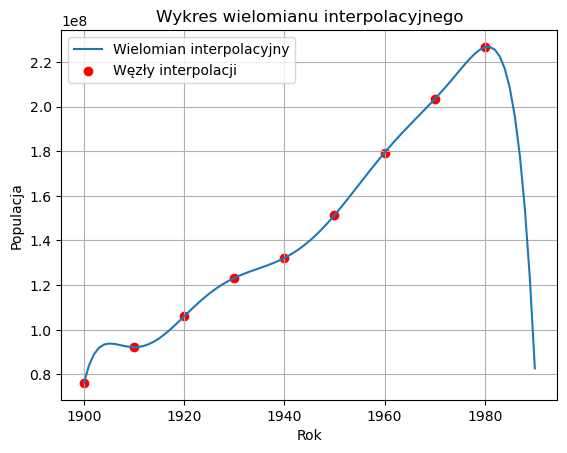

In [20]:
def horner(a_vec, x):
    ret = 0
    for a in a_vec: 
        ret = a + x * ret
    return ret

x_vec_1y = np.arange(1900, 1991, 1)
y_vec_1y = horner(a_vec, np.array([(x - 1940) / 40 for x in x_vec_1y])) 
plt.plot(x_vec_1y, y_vec_1y, label = 'Wielomian interpolacyjny')
plt.scatter(x_vec, y_vec, color = 'red', label = 'Węzły interpolacji')
plt.xlabel('Rok')
plt.ylabel('Populacja')
plt.title('Wykres wielomianu interpolacyjnego')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
real_1990 = 248_709_873
extr_1990 = horner(a_vec, (1990 - 1940) / 40)
err = abs(real_1990 - extr_1990)
print(f"Wartość z ekstrapolacji: {extr_1990:.0f}")
print(f"Prawdziwa wartość: {real_1990}")
print(f"Błąd względny: {err / real_1990:.2f}")

Wartość z ekstrapolacji: 82749141
Prawdziwa wartość: 248709873
Błąd względny: 0.67


Otrzymana z ekstrapolacji wartość jest znacznie mniejsza niż wartość prawdziwa.

Następnie obliczyliśmy wielomian interpolacyjny Lagrange'a korzystając z nastepujących wzorów.
$$ L_j(t) = \prod_{\substack{k=1 \\ k \neq j}}^n \frac{t - t_k}{t_j - t_k} \quad j = 1, \dots, n $$
$$ p_{n-1}(t) = y_1 l_1(t) + y_2 l_2(t) + \cdots + y_n l_n(t) $$

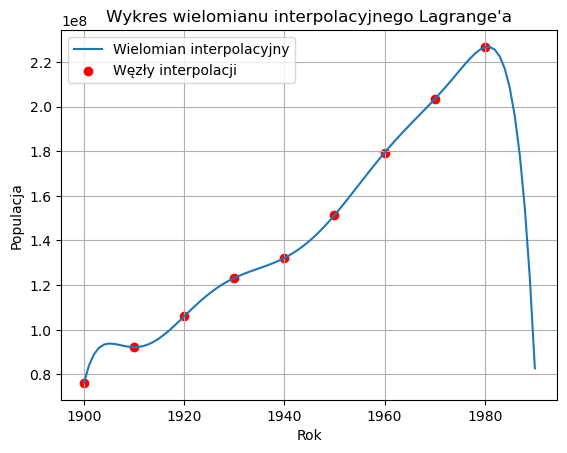

In [22]:
y_vec_1y_lagrange = np.zeros(len(x_vec_1y)) 
den = np.zeros(n)

for i in range(n):
    den[i] = np.prod(x_vec[:i] - x_vec[i]) * np.prod(x_vec[i + 1:] - x_vec[i])

for i in range(n):
    term = y_vec[i]
    for j in range(n):
        if j != i:
            term *= (x_vec_1y - x_vec[j])
    y_vec_1y_lagrange += term / den[i]

plt.plot(x_vec_1y, y_vec_1y_lagrange, label = 'Wielomian interpolacyjny')
plt.scatter(x_vec, y_vec, color = 'red', label = 'Węzły interpolacji')
plt.xlabel('Rok')
plt.ylabel('Populacja')
plt.title("Wykres wielomianu interpolacyjnego Lagrange'a")
plt.legend()
plt.grid(True)
plt.show()

Wykres jest praktycznie identyczny jak wykres otrzymany w podpunkcie c).
Potem obliczyliśmy wielomian interpolacyjny Newtona korzystając z następujących wzorów:
$$ \pi_j(t) = \prod_{k=1}^{j-1} (t - t_k) \quad j = 1, \dots, n $$
$$ p_{n-1}(t) = f[t_1] \pi_1(t) + f[t_1, t_2] \pi_2(t) + \cdots + f[t_1, t_2, \dots, t_n] \pi_n(t) $$

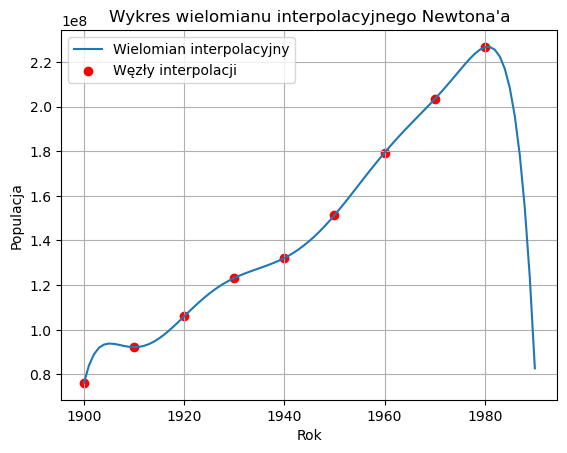

In [23]:
a_vec_newton = np.array(y_vec, copy = True, dtype = np.double)

for i in range(1, n):
    a_vec_newton[i:n] = (a_vec_newton[i:n] - a_vec_newton[i - 1]) / (x_vec[i:n] - x_vec[i - 1])

p_vec_newton = np.ones(shape = (n, len(x_vec_1y)))

for i in range(1, n):
    for j in range(i):
        p_vec_newton[i] *= (x_vec_1y - x_vec[j])

y_vec_1y_newton = np.dot(a_vec_newton, p_vec_newton)

plt.plot(x_vec_1y, y_vec_1y_newton, label = 'Wielomian interpolacyjny')
plt.scatter(x_vec, y_vec, color = 'red', label = 'Węzły interpolacji')
plt.xlabel('Rok')
plt.ylabel('Populacja')
plt.title("Wykres wielomianu interpolacyjnego Newtona'a")
plt.legend()
plt.grid(True)
plt.show()

Otrzymany wykres jest praktycznie taki sam jak poprzednio otrzymane wykresy.

In [24]:
rounded_y = np.around(y_vec, -6)

Następnie obliczyliśmy wielomian interpolacyjny korzystając z zaokrąglonych danych. Po zaokrągleniu danych za pomocą funkcji `np.around(y_vec, -6)` otrzymaliśmy następujące współczynniki wielomianu:

In [25]:
a_vec_rounded = np.linalg.solve(vander, rounded_y)
print(f"Współczynniki z zaokrąglonych danych: {a_vec_rounded}")
print(f"Współczynniki z podpunktu c): {a_vec}")

Współczynniki z zaokrąglonych danych: [-2.94196825e+08  1.86920635e+08  5.70311111e+08 -3.38488889e+08
 -3.56755556e+08  1.81111111e+08  1.00141270e+08  4.59571429e+07
  1.32000000e+08]
Współczynniki z podpunktu c): [-3.15180235e+08  1.89175576e+08  6.06291250e+08 -3.42668456e+08
 -3.74614715e+08  1.82527130e+08  1.02716315e+08  4.61307656e+07
  1.32164569e+08]


Współczynniki zaokrąglonego wielomianu różnią się od poprzednio wyznaczonych współczynników, różnica ta wynosi maksymalnie 7%.

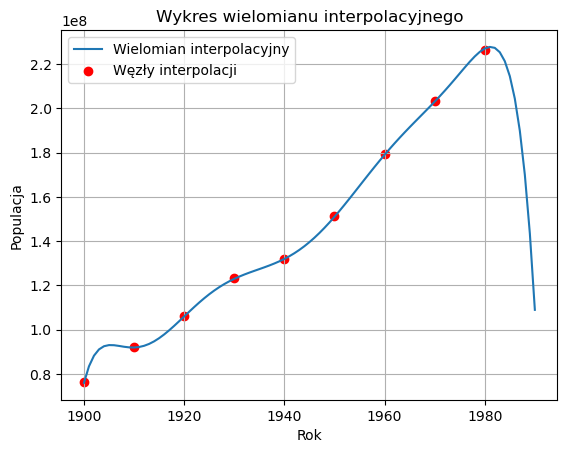

In [26]:
y_vec_1y_rounded = horner(a_vec_rounded, np.array([(x - 1940) / 40 for x in x_vec_1y])) 
plt.plot(x_vec_1y, y_vec_1y_rounded, label = 'Wielomian interpolacyjny')
plt.scatter(x_vec, y_vec, color = 'red', label = 'Węzły interpolacji')
plt.xlabel('Rok')
plt.ylabel('Populacja')
plt.title('Wykres wielomianu interpolacyjnego')
plt.legend()
plt.grid(True)
plt.show()

Wykres jest podobny do poprzednio otrzymanych wykresów, lecz wartości blisko roku 1990 są wyraźnie wyższe.

In [27]:
real_1990_rounded = 248_709_873
extr_1990_rounded = horner(a_vec_rounded, (1990 - 1940) / 40)
err_rounded = abs(real_1990_rounded - extr_1990_rounded)
print(f"Wartość z ekstrapolacji: {extr_1990_rounded:.0f}")
print(f"Prawdziwa wartość: {real_1990_rounded}")
print(f"Błąd względny: {err_rounded / real_1990_rounded:.2f}")

Wartość z ekstrapolacji: 109000000
Prawdziwa wartość: 248709873
Błąd względny: 0.56


Otrzymana wartość jest większa od wartości otrzymanej w podpunkcie d). Błąd względny dla ekstrapolacji za pomocą wielomianu wyznaczonego z zaokrąglonych danych jest trochę mniejszy niż dla wcześniej wyznaczonego wielomianu, lecz wciąż duży.

## Bibliografia

 - Materiały zamieszczone na platformie Microsoft Teams w zespole $\textit{MOwNiT 2025}$ w zakładce $\textit{Materiały z zajęć/lab03/lab-intro03.pdf}$